# *Welcome*

Welcome to the Showcase Notebook where the contents of bert_nn.py are showcased by demonstrating how it is executed on the twitter dataset. \
As is apparent after the setup, this python script imports a couple of functions from cleaning.py, a seperate python file where I wrote functions useful for compliling and oragnizing data into pandas dataframes which are easy to use

# *Setup*

In [1]:
import pandas as pd
import numpy as np

import torch                     #importing pytorch
import torch.nn as nn            #While this project uses pytorch for all ML purposes, one could also use tensorflow

from transformers import BertTokenizer  
from transformers import BertModel

from cleaning import convert      #function that turns data file into pandas dataframe
from cleaning import splitter     #function for splitting data into test,train and validation data:     returns  X_test, y_test, X_train, y_train, X_val, y_val

import matplotlib.pyplot as plt   #These two packages are used to visualize the evaluation of our ML models
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import dill as pickle   #We import dill instead of pickle here as pickle doesn't function as inteded for NN



## *Importing cleaned pandas dataframe*

In [2]:
root = "C:/Users/Bijan-PC/Documents/Coding/UNIL/Data Analysis/ADA_Project/ADA_Final/dat_cleaned/500"      #base location for where all data files are
filename = 'twit_df_500.csv'
df = convert(root,filename)            #Definining dataframe where all training and validation data will be pulled from

In [3]:
df["id"] = df.index  #creating id column

In [4]:
number_of_labels = len(df["label"].value_counts())          #number of labels (will be used when training)

In [5]:
#pd.set_option("display.max_colwidth", None)
#yelp_df.sample(20)

# *Pre-Processing*

In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not the cpu will be used
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4080 SUPER


### *Defining train-validation-test split (90-10-10)*

In [7]:
X = df.text.values
y = df.label.values


X_test, y_test, X_train, y_train, X_val, y_val = splitter(X,y)

In [8]:
y_val.size

300

In [9]:
#X = df.text.values
#y = df.label.values

#Original
#X_train, X_val, y_train, y_val =\
#    train_test_split(X, y, test_size=0.1, random_state=2020)

#Split off test data
#X_train_val, X_test, y_train_val, y_test =\
#    train_test_split(X, y, test_size=0.1, random_state=2020)

#Split remaining data into train and validation data
#X_train, X_val, y_train, y_val =\
#    train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=2020)

### *Function for cleaning text*

In [10]:
def text_preprocessing(text): 
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    #Remove line breaks
    text = re.sub(r'<br /><br />','',text).strip()

    return text

# *TOKENIZER*

Before tokenizing, we need to specify the maximum length of our sentences.

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the “attention mask”.

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [11]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### *Determining Maximum Length of Texts*

BERT model has a maximimum length of 512, as such a set of texts found to contain strings longer than 512 will be capped there.

In [12]:
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
if max_len < 513:
    MAX_LEN = max_len
else:
    MAX_LEN = 512                      
print('Max length: ', MAX_LEN)

Max length:  75


### *Creating a function to tokenize a set of texts*

In [13]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            truncation=True,
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [14]:
# Print sentence 0 and its encoded token ids  (Test to make sure tokenizer is functioning properly)
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  i feel the need to vent when i see the the idiotic behavior of others
Token IDs:  [101, 1045, 2514, 1996, 2342, 2000, 18834, 2043, 1045, 2156, 1996, 1996, 10041, 2594, 5248, 1997, 2500, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


Now let’s tokenize our data.

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## *Defining BERT Classifier*

In [16]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, number_of_labels

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### *Defining Training Loop and Evaluation functions*

In [18]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
            
        

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy, class_report, conf_matirx = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)

            
        print("\n")

    print(class_report)
    
    print(conf_matirx)

    print("Training complete!")

def plot_confusion_matrix(y_preds, y_true, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(number_of_labels, number_of_labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix")
    #plt.show()

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    val_preds = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        
        #Get the predictions which will be used for classification report
        confusion_preds = preds.cpu().numpy()
        val_preds.append(confusion_preds)

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    #Display classification report
    val_preds = np.concatenate(val_preds)
    class_report = classification_report(y_val, val_preds, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
    #cm = confusion_matrix(y_val, val_preds) 

    #Display confusion matrix
    cm = plot_confusion_matrix(val_preds, y_val ,labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

    return val_loss, val_accuracy, class_report, cm

### *Training Model*

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.778298   |     -      |     -     |   1.91   
   1    |   40    |   1.625109   |     -      |     -     |   1.57   
   1    |   60    |   1.315203   |     -      |     -     |   1.53   
   1    |   74    |   1.055333   |     -      |     -     |   1.10   
----------------------------------------------------------------------
   1    |    -    |   1.479002   |  0.849795  |   78.96   |   6.33   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.814782   |     -      |     -     |   1.64   
   2    |   40    |   0.721218   |     -      |     -     |   1.56   
   2    |   60    |   0.642428   |     -      |     -     |   1.5

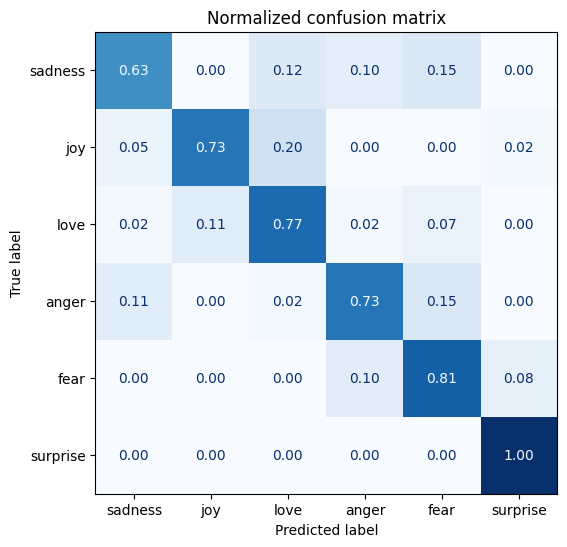

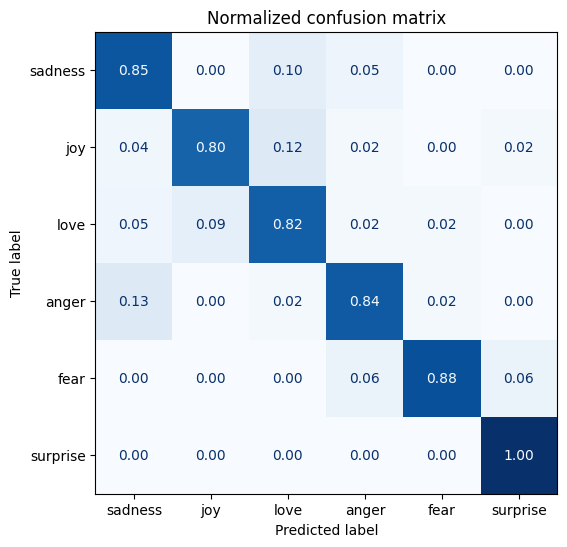

In [19]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
torch.save(bert_classifier, 'tomato.pkl')

### *Further Evaluation*

# *Making Predictions on Test Data*

### *Defining Prediction Function*

In [100]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [101]:
test_df = {'label': y_test, 'text' : X_test}
test_data = pd.DataFrame(data=test_df)

In [102]:
#test_words = {'text': ['go fuck yourself you ugly piece of shit motherfucker', 'I love you']}
#test_data = pd.DataFrame(data=test_words)

In [103]:
test_data

,label,text
0,3,i have sacrificed so much for this man and whe...
1,0,i loved the cozy color but all the dark items ...
2,2,i am actually finding myself sympathetic to ho...
3,2,i feel a tender kiss on my forehead
4,3,i felt slighted makes me feel petty and certai...
...,...,...
295,1,i drank alomo with a bottle of sprite and i of...
296,3,i found myself feeling increasingly agitated a...
297,4,i have artist block i feel inhibited i plan in...
298,3,i have resisted writing anything about the us ...


In [104]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [109]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.95

In [110]:
#returns numpy array with the index of the highest probability for each prediction. This index is indicative of the emotion (label)
preds = np.argmax(probs, axis=1)

In [111]:
preds

array([0, 0, 2, 2, 3, 5, 5, 0, 5, 3, 2, 4, 3, 3, 5, 3, 1, 5, 5, 4, 3, 1,
       5, 3, 5, 2, 5, 4, 3, 3, 5, 3, 0, 0, 2, 0, 5, 2, 4, 4, 2, 5, 4, 2,
       2, 4, 5, 1, 5, 2, 0, 5, 4, 0, 2, 4, 3, 5, 4, 0, 5, 0, 4, 3, 2, 0,
       4, 0, 4, 0, 0, 5, 3, 4, 4, 3, 2, 5, 2, 0, 1, 0, 4, 2, 4, 0, 5, 4,
       4, 0, 0, 2, 0, 3, 4, 2, 0, 0, 3, 2, 0, 1, 2, 1, 1, 0, 3, 0, 5, 1,
       2, 2, 3, 1, 3, 0, 5, 5, 0, 5, 5, 0, 4, 3, 2, 4, 5, 1, 5, 4, 2, 1,
       5, 1, 1, 1, 4, 3, 1, 2, 4, 4, 2, 1, 5, 2, 1, 3, 4, 3, 1, 4, 5, 3,
       4, 4, 2, 4, 5, 0, 4, 3, 3, 0, 5, 5, 0, 0, 3, 5, 1, 5, 0, 1, 0, 0,
       5, 2, 5, 4, 3, 3, 3, 0, 3, 5, 3, 1, 4, 3, 2, 4, 5, 0, 1, 2, 3, 0,
       0, 2, 2, 5, 5, 3, 0, 2, 5, 5, 0, 2, 0, 1, 5, 3, 0, 2, 1, 1, 0, 4,
       5, 5, 4, 3, 4, 2, 3, 4, 5, 1, 4, 0, 3, 3, 3, 0, 4, 0, 5, 0, 1, 5,
       2, 0, 2, 0, 3, 5, 2, 5, 2, 0, 3, 5, 4, 1, 5, 0, 0, 4, 3, 1, 1, 5,
       3, 5, 5, 3, 1, 2, 2, 3, 4, 4, 0, 5, 0, 0, 4, 2, 5, 1, 1, 2, 2, 1,
       5, 2, 3, 1, 0, 0, 1, 2, 0, 1, 3, 0, 3, 1], d

In [112]:
#returns f1 score for test data, comparing the predicted emotions with the real labeled emotions
f1_score(test_data['label'], preds, average="weighted")

0.8205636696996631

# May prove useful when making UI

In [113]:
my_string = ['I am in love with dogs!']
abcdefg = {'text' : my_string}
test_words = pd.DataFrame(data=abcdefg)

In [114]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_words.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [115]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.95

In [116]:
#returns numpy array with the index of the highest probability for each prediction. This index is indicative of the emotion (label)
preds = np.argmax(probs, axis=1)

In [117]:
#twitter specific: The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)
predicted_emotions = []
for pred in preds:
    if pred == 0:
        predicted_emotion = 'Sadness'
        predicted_emotions.append(predicted_emotion)
    elif pred ==1:
        predicted_emotion = 'Joy'
        predicted_emotions.append(predicted_emotion)
    elif pred ==2:
        predicted_emotion = 'Love'
        predicted_emotions.append(predicted_emotion)
    elif pred ==3:
        prediced_emotion = 'Anger'
        predicted_emotions.append(predicted_emotion)
    elif pred ==4:
        predicted_emotion = 'Fear'
        predicted_emotions.append(predicted_emotion)
    elif pred ==5:
        prediced_emotion = 'Surprise'
        predicted_emotions.append(predicted_emotion)


In [118]:
predicted_emotions

['Love']